<a href="https://colab.research.google.com/github/seunghak421/section2_project/blob/main/%08AI_13_%EB%B0%B1%EC%8A%B9%ED%95%99_section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

뇌졸중


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install category_encoders
!pip install pdpbox
!pip install eli5
!pip install catboost
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
from ipywidgets import interact, fixed
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import json
import sklearn
import shap
import eli5
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data_stroke='/content/drive/MyDrive/Stroke.csv'

In [5]:
import pandas as pd
df=pd.read_csv(data_stroke)

In [6]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [7]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
#이거 드롭하지말고 평균값으로 바꿀까??
df['bmi'] = df['bmi'].fillna(value=df['bmi'].mean())

In [9]:
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [10]:
df=df.rename(columns={'ever_married':'married','avg_glucose_level':'glucose_level','smoking_status':'smoke','Residence_type':'Residence'})

In [11]:
df.gender.replace({'Male':1,'Female':0,'Other':2},inplace = True)
df.married.replace({'Yes':1,'No':0},inplace = True)
df.Residence.replace({'Urban':1,'Rural':0},inplace = True)

df.smoke.replace({'Unknown':0,'never smoked':1,'formerly smoked':3,'smokes':4},inplace = True)

In [12]:
df['smoke'].unique()

array([3, 1, 4, 0])

In [13]:
df['Residence'].unique()

array([1, 0])

In [14]:
df['glucose_level'].unique()

array([228.69, 202.21, 105.92, ...,  82.99, 166.29,  85.28])

In [15]:
df['smoke'].unique()

array([3, 1, 4, 0])

In [16]:
df['work_type']

0             Private
1       Self-employed
2             Private
3             Private
4       Self-employed
            ...      
5105          Private
5106    Self-employed
5107    Self-employed
5108          Private
5109         Govt_job
Name: work_type, Length: 5110, dtype: object

In [17]:
df.describe()

,id,gender,age,hypertension,heart_disease,married,Residence,glucose_level,bmi,smoke,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,0.414286,43.226614,0.097456,0.054012,0.656164,0.508023,106.147677,28.893237,1.507436,0.048728
std,21161.721625,0.493044,22.612647,0.296607,0.226063,0.475034,0.499985,45.283560,7.698018,1.458583,0.215320
min,67.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000
25%,17741.250000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,77.245000,23.800000,0.000000,0.000000
50%,36932.000000,0.000000,45.000000,0.000000,0.000000,1.000000,1.000000,91.885000,28.400000,1.000000,0.000000
75%,54682.000000,1.000000,61.000000,0.000000,0.000000,1.000000,1.000000,114.090000,32.800000,3.000000,0.000000
max,72940.000000,2.000000,82.000000,1.000000,1.000000,1.000000,1.000000,271.740000,97.600000,4.000000,1.000000


In [18]:
df.drop('id',axis=1,inplace=True)

In [19]:
df.drop('married',axis=1,inplace=True)

In [20]:
df.drop('work_type',axis=1,inplace=True)

In [21]:
df.drop('gender',axis=1,inplace=True)

In [22]:
df

,age,hypertension,heart_disease,Residence,glucose_level,bmi,smoke,stroke
0,67.0,0,1,1,228.69,36.600000,3,1
1,61.0,0,0,0,202.21,28.893237,1,1
2,80.0,0,1,0,105.92,32.500000,1,1
3,49.0,0,0,1,171.23,34.400000,4,1
4,79.0,1,0,0,174.12,24.000000,1,1
...,...,...,...,...,...,...,...,...
5105,80.0,1,0,1,83.75,28.893237,1,0
5106,81.0,0,0,1,125.20,40.000000,1,0
5107,35.0,0,0,0,82.99,30.600000,1,0
5108,51.0,0,0,0,166.29,25.600000,3,0


In [23]:
target='stroke'

In [24]:
#프로젝트에 사용할 데이터는 뇌졸증 환자들에 관한 데이터 입나다.
#나이,성별,고혈압,심장질환,결혼여부,거주지,혈당,체질량,흡연여부로 데이터셋을 구성합니다.
#타겟은 뇌졸증 입니다.

In [25]:
df['stroke'].value_counts(normalize = True)
#클래스 2개 비율-> 불균형
#분류
#불균형 데이터 (accuracy만 사용해서는 안된다.)
#오차행렬,정밀도와 재현율,f1스코어,roc곡선과 auc등 을 같이 사용한다.

0    0.951272
1    0.048728
Name: stroke, dtype: float64

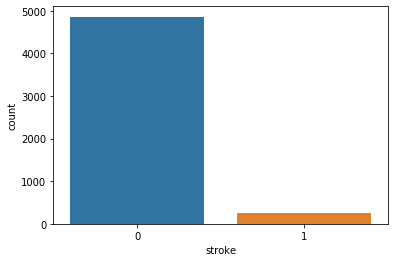

In [26]:
import seaborn as sns
tmp = df['stroke']
sns.countplot(x=tmp)

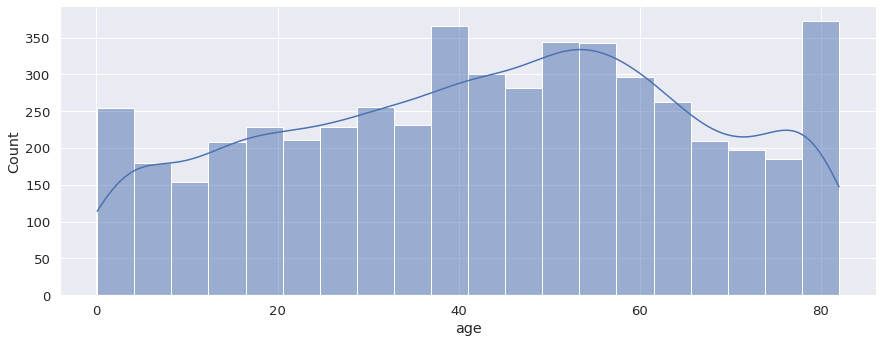

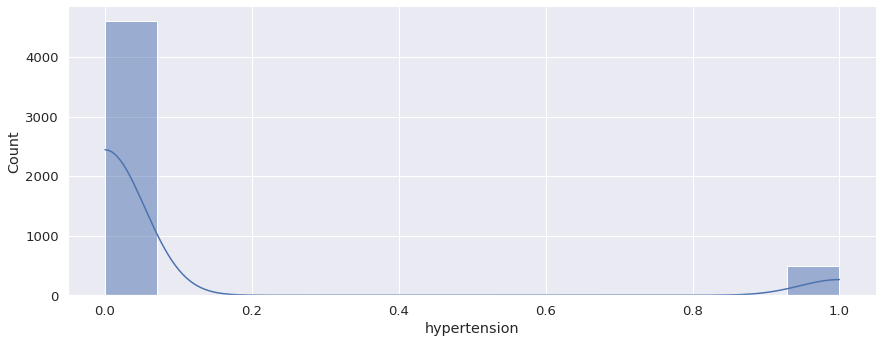

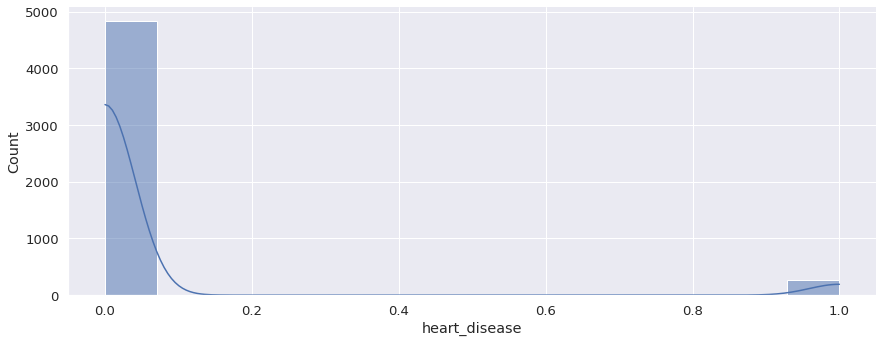

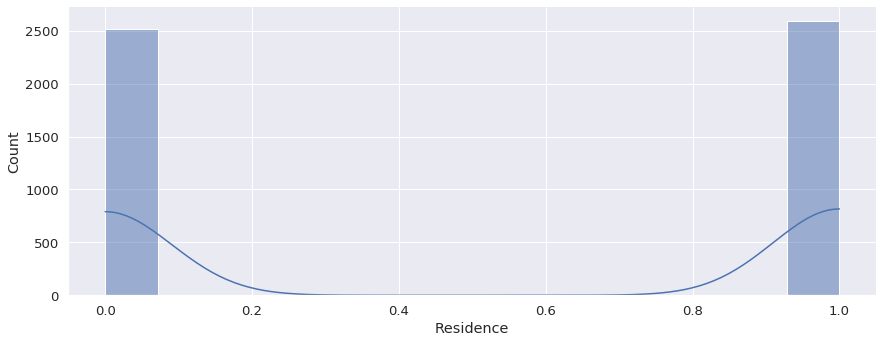

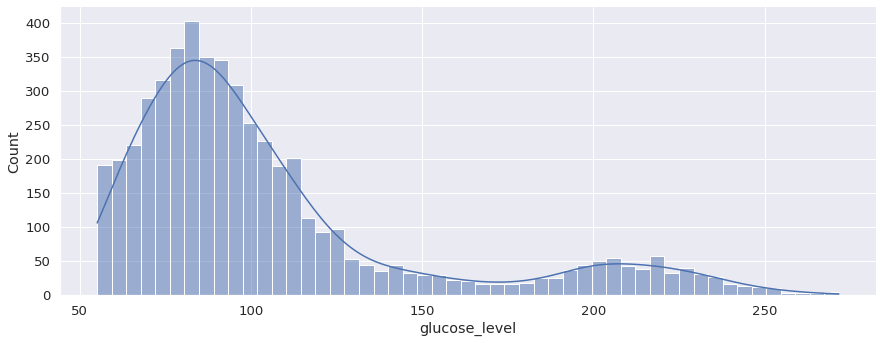

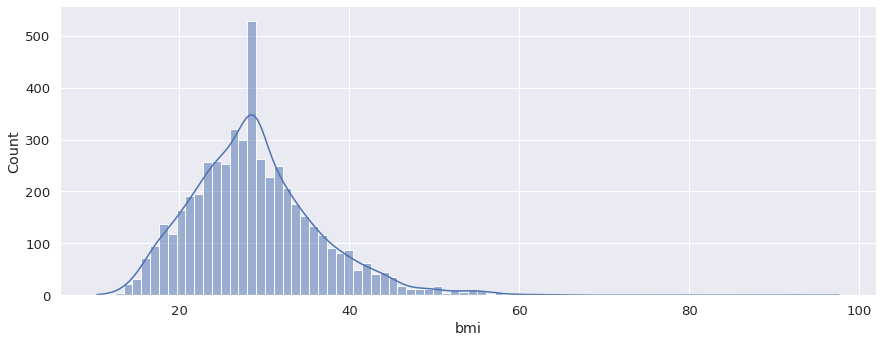

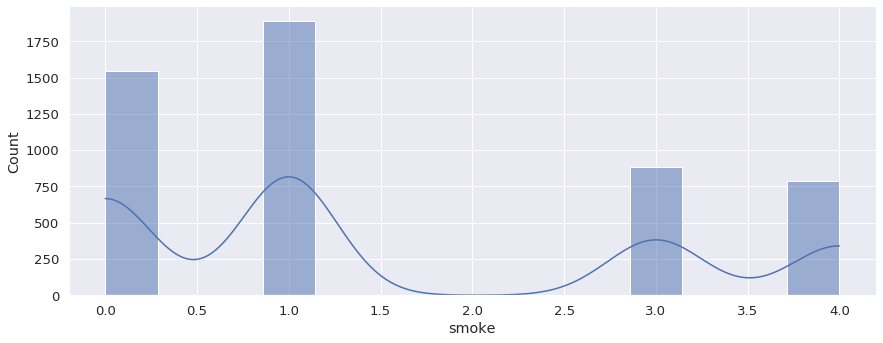

In [27]:
other = df.drop(['stroke'],axis=1).columns
sns.set(font_scale=1.2)

for i in other:
  sns.displot(df[i], height = 5, aspect = 2.5, kde=True);

In [28]:
#성별,나이,고혈압,심장병,거주지역,포도당 수치,체질량지수,흡연여부

In [29]:
#결혼,직업은 버리자

# 가설
나이가 많아질수록 뇌졸중에 걸릴확률이 높다.

흡연을 하면 높다.

bmi가 높으면 가능성이 높다


# 평가지표
불균형 분포이다.
'f1 score'와 'roc_auc score'를 평가지표로 사용할 것이다.

In [30]:
df['stroke'].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

In [31]:
# 불균형 클래스 가중치 
ratio = 0.951272/0.048728

In [32]:
df.groupby('smoke')['stroke'].mean()

smoke
0    0.030440
1    0.047569
3    0.079096
4    0.053232
Name: stroke, dtype: float64

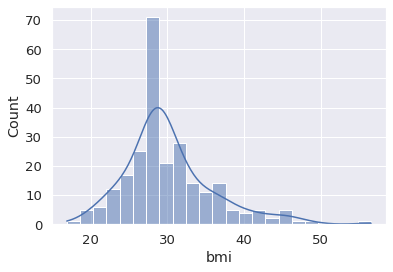

In [33]:
#체질량과 뇌졸중
sick = df[df['stroke'] == 1]
sns.histplot(sick['bmi'],kde=True);

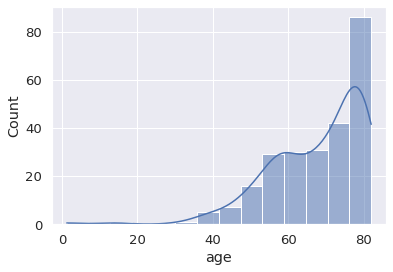

In [34]:
#나이와의 관계
sns.histplot(sick['age'],kde=True);

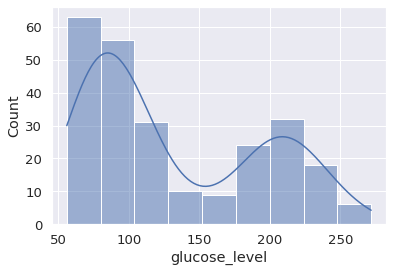

In [35]:
sns.histplot(sick['glucose_level'],kde=True);

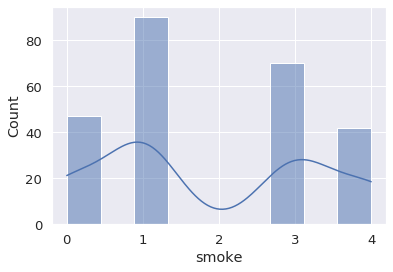

In [36]:
sns.histplot(sick['smoke'],kde=True);

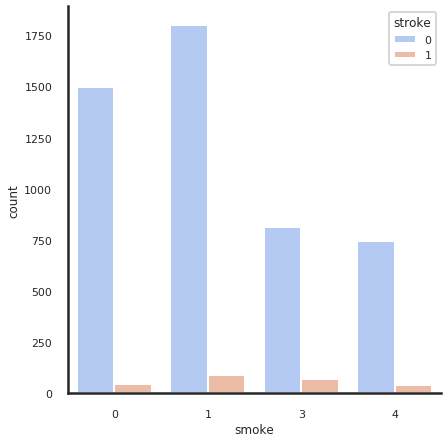

In [37]:
fig = plt.figure(figsize=(14,11))
gs = fig.add_gridspec(3,4)
sns.set_style("white")
sns.set_context("poster", font_scale = 0.5)

ax_gender_stroke = fig.add_subplot(gs[:2,:2])
sns.countplot(x='smoke', hue='stroke', data=df, ax=ax_gender_stroke, palette='coolwarm')
sns.despine()

# 모델 학습

In [38]:
from imblearn.over_sampling import BorderlineSMOTE



In [39]:
target = 'stroke'
feature = df.drop(columns=[target]).columns

# test/train/val으로 데이터셋 구분하기
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, random_state=2)
train, val = train_test_split(train, random_state=2)


# 훈련세트-독립/종속변수 지정 + 테스트세트-독립/종속변수 지정
X_train = train[feature]
y_train = train[target]
X_test = test[feature]
y_test = test[target]
X_val = val[feature]
y_val = val[target]


#불균형 데이터라 f1스코어가 너무 안나와서
smote = BorderlineSMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test)
X_val, y_val = smote.fit_resample(X_val, y_val)

In [40]:
train.shape, val.shape, test.shape

((2874, 8), (958, 8), (1278, 8))

In [41]:
X_train

,age,hypertension,heart_disease,Residence,glucose_level,bmi,smoke
0,56.000000,0,0,0,156.180000,25.300000,4
1,32.000000,0,0,1,79.540000,28.100000,0
2,56.000000,0,0,0,244.300000,37.300000,1
3,35.000000,0,0,0,115.920000,28.893237,3
4,47.000000,0,0,0,140.390000,25.500000,1
...,...,...,...,...,...,...,...
5465,41.171556,0,0,0,96.297819,29.817156,3
5466,68.898008,0,0,0,79.513738,25.887690,1
5467,77.491362,0,0,0,58.267985,29.963728,2
5468,72.578629,0,1,0,219.142187,29.084577,1


In [42]:
# XGBoost
pipe_x = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(scale_pos_weight=ratio, random_state=24,n_estimatiors=10,max_depth=3,n_jobs=-1))

pipe_x.fit(X_train, y_train)
y_predx = pipe_x.predict(X_val)
print('훈련 정확도', pipe_x.score(X_train, y_train))
print('검증 정확도', pipe_x.score(X_val, y_val))
print('Report \n',classification_report(y_val, y_predx))
print('f1 스코어',f1_score(y_val, y_predx))
print('auc점수 : ', roc_auc_score(y_val, y_predx))

훈련 정확도 0.8288848263254114
검증 정확도 0.7925356750823271
Report 
               precision    recall  f1-score   support

           0       0.90      0.66      0.76       911
           1       0.73      0.93      0.82       911

    accuracy                           0.79      1822
   macro avg       0.82      0.79      0.79      1822
weighted avg       0.82      0.79      0.79      1822

f1 스코어 0.8175675675675675
auc점수 :  0.7925356750823271


In [43]:
# xgboost
pipe_xc = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(scale_pos_weight=ratio, random_state=2)
)

distsxc = {  
    'ordinalencoder__handle_missing': ['value'],
    'simpleimputer__strategy': ['mean', 'median'], 
    'xgbclassifier__n_estimators': randint(50, 500), 
    'xgbclassifier__max_depth': randint(0, 15),
    'xgbclassifier__min_samples_leaf': randint(2, 20)
}

clfxg = RandomizedSearchCV(
    pipe_xc, 
    param_distributions=distsxc, 
    n_iter=30, 
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

clfxg.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [44]:
print('최적 하이퍼파라미터: ', clfxg.best_params_)

pipe_bxc = clfxg.best_estimator_
y_val_predbxc = pipe_bxc.predict(X_val)
y_train_predbxc = pipe_bxc.predict(X_train)
print('훈련 f1 score: ', f1_score(y_train, y_train_predbxc))
print('검증 f1 score: ', f1_score(y_val, y_val_predbxc))
print('Report \n',classification_report(y_val, y_val_predbxc))
print('auc점수 : ', roc_auc_score(y_val, y_val_predbxc))

최적 하이퍼파라미터:  {'ordinalencoder__handle_missing': 'value', 'simpleimputer__strategy': 'mean', 'xgbclassifier__max_depth': 14, 'xgbclassifier__min_samples_leaf': 13, 'xgbclassifier__n_estimators': 394}
훈련 f1 score:  1.0
검증 f1 score:  0.7888544891640867
Report 
               precision    recall  f1-score   support

           0       0.75      0.93      0.83       911
           1       0.90      0.70      0.79       911

    accuracy                           0.81      1822
   macro avg       0.83      0.81      0.81      1822
weighted avg       0.83      0.81      0.81      1822

auc점수 :  0.8128430296377608


roc


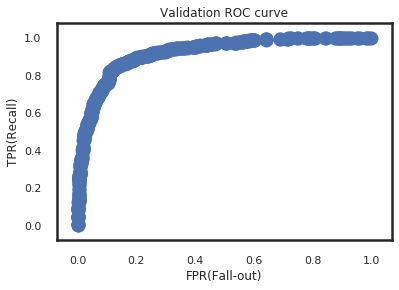

In [45]:


y_pred_proba = pipe_bxc.predict_proba(X_val)[:, 1]

# roc_curve(타겟값, prob of 1)
fprv, tprv, thresholdsv = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fprv, 
    'TPRate(Recall)': tprv, 
    'Threshold': thresholdsv
})

plt.scatter(fprv, tprv)
plt.title('Validation ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

idx: 266 , threshold: 0.05633951


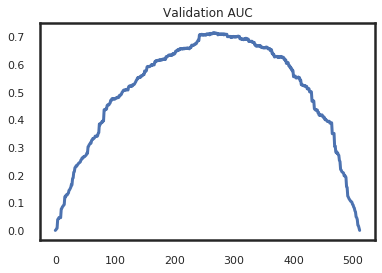

In [46]:
# 최적의 threshold & AUC
optimal_idxv = np.argmax(tprv - fprv)
optimal_thresholdv = thresholdsv[optimal_idxv]

print('idx:', optimal_idxv, ', threshold:', optimal_thresholdv)
plt.title('Validation AUC')
plt.plot(tprv-fprv);

In [47]:
# threshold 설정 및 레포트
y_v_pred_optimal = y_pred_proba >= optimal_thresholdv
print('Report \n',classification_report(y_val, y_v_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_val, y_v_pred_optimal)
print('검정 정확도', pipe_bxc.score(X_val, y_val))
print('val_f1 스코어',f1_score(y_val, y_v_pred_optimal))
print('val_auc점수 : ', auc_score)

Report 
               precision    recall  f1-score   support

           0       0.85      0.87      0.86       911
           1       0.87      0.85      0.86       911

    accuracy                           0.86      1822
   macro avg       0.86      0.86      0.86      1822
weighted avg       0.86      0.86      0.86      1822

검정 정확도 0.8128430296377607
val_f1 스코어 0.8560311284046693
val_auc점수 :  0.8578485181119649


# 최종

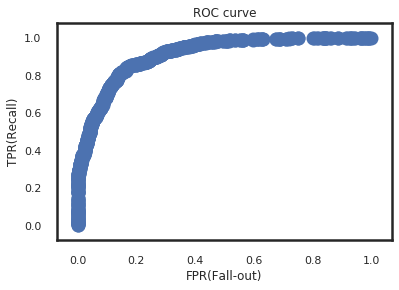

In [48]:
# 테스트 데이터 모델에 넣어서 roc curve
y_test_pred_proba = pipe_bxc.predict_proba(X_test)[:, 1]

# roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

idx: 449 , test_threshold: 0.034310367


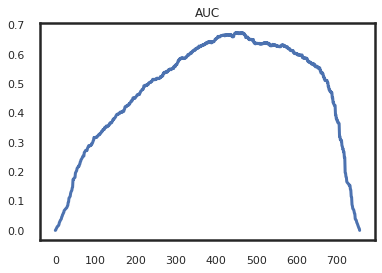

In [49]:
# 최적의 threshold & AUC
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', test_threshold:', optimal_threshold)
plt.title('AUC')
plt.plot(tpr-fpr);

In [50]:
# threshold 설정 및 레포트
y_test_pred_optimal = y_test_pred_proba >= optimal_threshold
print('Report \n',classification_report(y_test, y_test_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_test, y_test_pred_optimal)
print('테스트 정확도', pipe_bxc.score(X_test, y_test))
print('test_f1 스코어',f1_score(y_test, y_test_pred_optimal))
print('test_auc점수 : ', auc_score)

Report 
               precision    recall  f1-score   support

           0       0.84      0.83      0.84      1215
           1       0.83      0.84      0.84      1215

    accuracy                           0.84      2430
   macro avg       0.84      0.84      0.84      2430
weighted avg       0.84      0.84      0.84      2430

테스트 정확도 0.77119341563786
test_f1 스코어 0.8377049180327868
test_auc점수 :  0.837037037037037


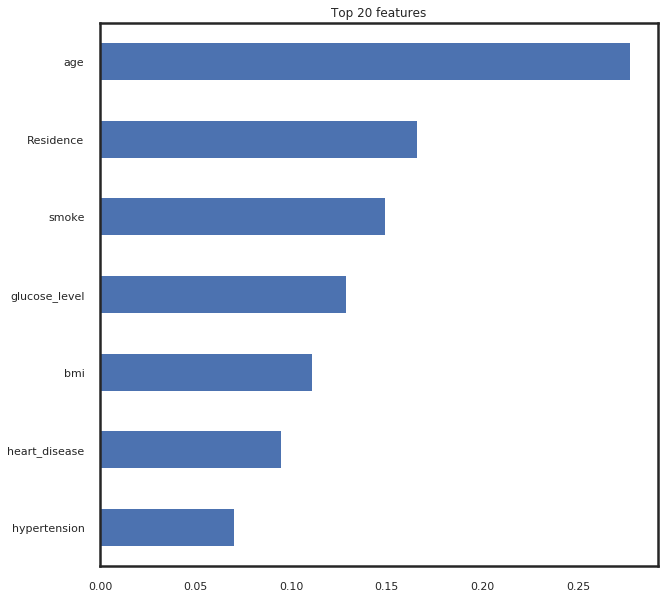

In [51]:
# feature importance
processor = make_pipeline(
    OrdinalEncoder(handle_missing='value'), 
    SimpleImputer(strategy='mean')
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

model = XGBClassifier(learning_rate=0.2, max_depth= 4, n_estimators=308, 
                           scale_pos_weight=ratio, random_state=2).fit(X_train_processed, y_train)

importances = pd.Series(model.feature_importances_, X_train.columns)

%matplotlib inline


n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [52]:
# permutation importance
permuter = PermutationImportance(model, 
    scoring='f1', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
).fit(X_val_processed, y_val)

feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

hypertension     0.004266
heart_disease    0.004755
Residence        0.007806
smoke            0.021570
glucose_level    0.045912
bmi              0.057201
age              0.313798
dtype: float64

In [53]:

eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.3138 ± 0.0147,age
0.0572 ± 0.0105,bmi
0.0459 ± 0.0098,glucose_level
0.0216 ± 0.0058,smoke
0.0078 ± 0.0053,Residence
0.0048 ± 0.0040,heart_disease
0.0043 ± 0.0020,hypertension


In [54]:
# Shap force plot


explainer = shap.TreeExplainer(model)
row = X_test.iloc[:100]
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

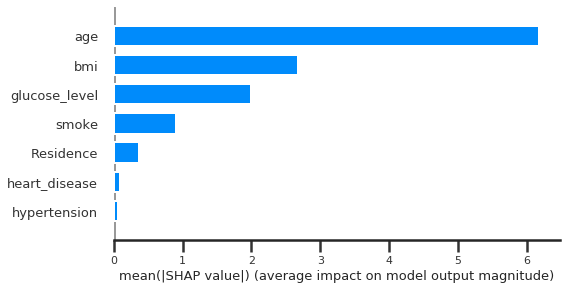

In [55]:
# Shap summary plot
shap.summary_plot(shap_values, X_test.iloc[:100], plot_type="bar")


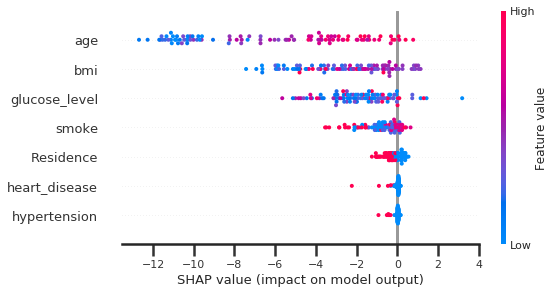

In [56]:

shap.summary_plot(shap_values, X_test.iloc[:100])